In [64]:
# import libraries
import re
import nltk
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud

In [65]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\citrusbug\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\citrusbug\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\citrusbug\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\citrusbug\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\citrusbug\AppData\Roaming\nltk_data.

True

In [66]:
ctweet_train = 'data/ctweet/train.csv'

ctweet_train_df = pd.read_csv(ctweet_train)

ctweet_train_df.drop(ctweet_train_df[ctweet_train_df['Y'] == 1].index, inplace=True) # dropping neatural statements
ctweet_train_df.loc[ctweet_train_df['Y'] == 2, 'Y'] = 1 # changing postive value from 2 to 1 for classification

In [67]:
ctweet_test = 'data/ctweet/test.csv'

ctweet_test_df = pd.read_csv(ctweet_test)

ctweet_test_df.drop(ctweet_test_df[ctweet_test_df['Y'] == 1].index, inplace=True) # dropping neatural statements
ctweet_test_df.loc[ctweet_test_df['Y'] >= 1, 'Y'] = 1 # changing postive value from 2 to 1 for classification

In [68]:
stopwords_list = set(stopwords.words("english"))
no_stopwords = {"not","don't",'aren','don','ain',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', 
                "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', 
                "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"}

stopwords_list -= no_stopwords

In [69]:
re_negation = re.compile("n't ")
def negation_abbreviated_to_standard(sent):
    sent = re_negation.sub(" not ", sent)
    return sent

# create preprocess_text function
def preprocess_text(text):
    # Transform abbreviated negations to the standard form
    text = negation_abbreviated_to_standard(text)

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords_list]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

# apply the function to ctweet_train_df
ctweet_train_df['text'] = ctweet_train_df['text'].apply(preprocess_text)

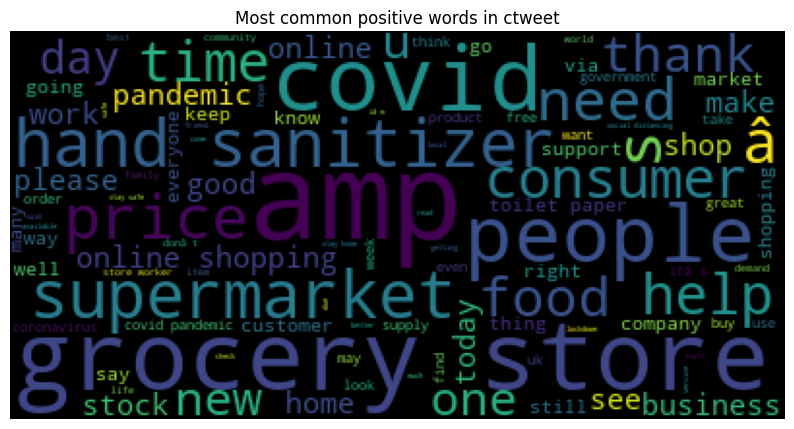

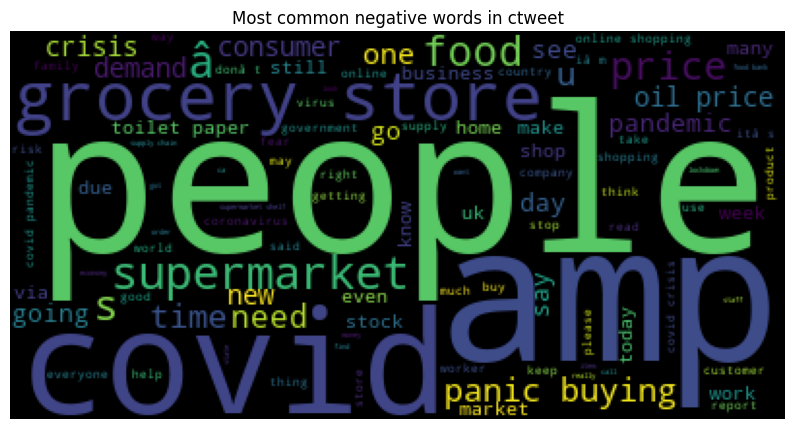

In [70]:
positive_wc = WordCloud(background_color='black', max_words=100)
positive_wc.generate(' '.join(text for text in ctweet_train_df.loc[ctweet_train_df['Y'] >= 1, 'text']))

negative_wc = WordCloud(background_color='black', max_words=100)
negative_wc.generate(' '.join(text for text in ctweet_train_df.loc[ctweet_train_df['Y'] == 0, 'text']))

plt.figure(figsize=(10,15))
plt.imshow(positive_wc)
plt.axis('off')
plt.title("Most common positive words in ctweet")

plt.figure(figsize=(10,15))
plt.imshow(negative_wc)
plt.axis('off')
plt.title("Most common negative words in ctweet")
plt.show()

In [71]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# create get_sentiment function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# apply get_sentiment function
ctweet_train_df['sentiment'] = ctweet_train_df['text'].apply(get_sentiment)

In [72]:
print(confusion_matrix(ctweet_train_df['Y'], ctweet_train_df['sentiment']))

[[ 7924  7474]
 [  343 17703]]


In [73]:
ctweet_train_text_series = ctweet_train_df.iloc[:,0]

In [74]:
ctweet_train_prediction_series = ctweet_train_df.iloc[:,1]

In [75]:
ctweet_test_text_series = ctweet_test_df.iloc[:,0]

In [76]:
ctweet_test_prediction_series = ctweet_test_df.iloc[:,1]

In [77]:
ctweet_train_df

,text,Y,sentiment
0,advice talk neighbour family exchange phone nu...,1,1
1,coronavirus australia : woolworth give elderly...,1,1
2,"food stock one empty ... please , panic , enou...",1,1
3,", ready go supermarket outbreak . not 'm paran...",0,1
4,news regionâs first confirmed covid- case cam...,1,1
...,...,...,...
41145,never weâd situation & amp ; world going supe...,1,1
41146,"definitely man . feel like fall , need honor h...",1,1
41148,response complaint provided citing covid- rela...,0,0
41149,know itâs getting tough rationing toilet pape...,1,1


In [78]:
# vectorise the text for the logistic regression.
vectorizer = TfidfVectorizer(max_features=20000, ngram_range = (1,2))
ctweet_train_text_series_vectorized = vectorizer.fit_transform(ctweet_train_text_series)

In [79]:
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
model.fit(ctweet_train_text_series_vectorized, ctweet_train_prediction_series)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [80]:
predictions = model.predict(vectorizer.transform(ctweet_test_text_series))

In [81]:
accuracy_score(ctweet_test_prediction_series, predictions)

0.8505819440075495

In [82]:
r2_score(ctweet_test_prediction_series, predictions)

0.40187980914340293

In [83]:
new_review = ['The food was not good', 'The food was very bad']
print(model.predict(vectorizer.transform(new_review)))

[1 0]


In [84]:
# filename = "ctweet_prediction_model.pickle"
# pickle.dump(model, open(filename, "wb"))

In [85]:
# filename = "count_vectorizer.pkl"
# pickle.dump(vectorizer, open(filename, "wb"))